https://jcollopy-tulane.github.io

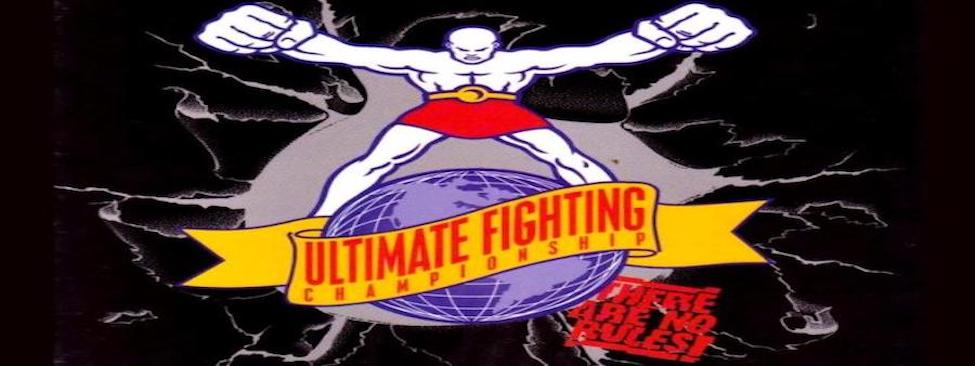

# Exploring Decision Fights in the UFC
## - John Collopy

### Links to Each Section

1. [Motivation](#Introduction)
2. [Further Reading](#Further-Reading)
3. [ETL](#ETL)
4. [EDA](#EDA)
5. [Model Selection](#Model-Selection)
6. [Conclusions](#Conclusions)

# Motivation

I find Mixed Martial Arts compelling because of the unpredictability in competition. Danger is always imminent, and an exciting ending is always on the table. That being said, a large number of fights do not end in a decisive knockout or submission, and so three judges are left to decide who won the fight. The three judges are supposed to judge the fight according to the [Unified Rules of Mixed Arts](https://www.abcboxing.com/wp-content/uploads/2020/02/unified-rules-mma-2019.pdf). 

Judges assess the fight according to three criteria: 

- Effective striking/grappling 
- Effective aggressiveness
- Control of the fighting area 

However, this language is subjective and leaves room for interpretation. Thus, perhaps unsurprisingly, fans and fighters find themselves frustrated with how judges decide fights.

The goal of this project is to use fight data to predict the results of fights and assess the impact of fighter output. In doing so, we will gain a better understand of the criteria by which judges score fights.

# Further Reading

For those interested in learning more about the judging criteria, controversial decisions, or frustrated athletes, a few links are provided below.

 - [Quick and Easy Guide to MMA Judging Criteria](https://news.bet365.com/en-gb/article/ufc-fight-scoring-system-and-decisions-explained/2023022017090311259)
 - [Controversial Decisions in UFC History](https://bleacherreport.com/articles/2072171-the-10-most-controversial-judging-decisions-in-ufc-history)
 - [Athlete Upset With Judges After Controversial Loss](https://www.mmafighting.com/2023/6/6/23750061/kai-kara-france-rips-judges-after-controversial-ufc-vegas-74-decision-that-cost-me-100000)

# ETL 

The data used for this project comes from [ufcstats.com](http://www.ufcstats.com/statistics/events/completed?page=all), a website containing data from every UFC fight. This site contains multiple "layers", from which separate datasets were created. The first "layer" of this site contains links that track simple counting statistics for each fight, such as number of knockdowns, significant strikes, takedowns, and submission attempts. This data will assist in the initial EDA, as I will create charts displaying the distibutions of the winner's differentials with respect to these features. The second "layer" of this site contains more advanced metrics about each fight. This data will be merged with the first dataset in order to build a more detailed model that will predict fight results.

Important Note: This dataset contains all UFC fights up to and including the Islam Makhachev vs. Alexander Volkanovski match, which took place on October 21, 2023.

In [1]:
# Importing the necessary packages to scrape the data

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup as bs
import requests
from tqdm import tqdm
import re

In [2]:
# Retrieving the URL that contains links to all fight data

url = "http://www.ufcstats.com/statistics/events/completed?page=all"
headers = {"User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.3 Safari/605.1.15"}


html = requests.get(url, headers = headers)
soup = bs(html.content, "html.parser")

I now have the content for the site, and I will put the link containing data for each fight into a list, which will then be scraped for fight data.

### Scraping the First "Layer" of Data

In [3]:
# Putting each link on the home page into a list

first_layer = []
for link in tqdm(soup.find_all('a', href=True), desc="Scraping First Layer"):
    page = link['href']
    first_layer.append(page)

Scraping First Layer: 100%|███████████████| 694/694 [00:00<00:00, 293698.62it/s]


In [4]:
# Removing all links that do not contain relevant fight data

first_layer = first_layer[11:-16] 

I now have some preliminary data for each fight. The data must be cleaned and requires some feature engineering, but since the data took some time to scrape, I will now save the dataframe as a .csv file, which will be imported later.

In [5]:
# Extracting Data From the "first layer" of the UFC Stats site and creating a dataframe

main_dataframe = pd.DataFrame()

for url in tqdm(first_layer, desc="Scraping First Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "html.parser")
    table = soup.find("table")
    data = pd.read_html(str(table))
    adj_data = pd.concat(data)
    
    event = soup.find("h2", class_="b-content__title").text.strip()
    

    adj_data["Event"] = event
    
    main_dataframe = pd.concat([main_dataframe, adj_data], ignore_index=True)
    
main_dataframe.head()

Scraping First Layer: 100%|███████████████████| 667/667 [04:59<00:00,  2.22it/s]


,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event
0,win,Islam Makhachev Alexander Volkanovski,1 0,24 4,0 0,0 0,Lightweight,KO/TKO Kick,1,3:06,UFC 294: Makhachev vs. Volkanovski 2
1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
2,nc nc,Magomed Ankalaev Johnny Walker,0 0,13 14,1 0,0 0,Light Heavyweight,CNC,1,3:13,UFC 294: Makhachev vs. Volkanovski 2
3,win,Ikram Aliskerov Warlley Alves,1 0,26 12,0 0,0 0,Middleweight,KO/TKO Punches,1,2:07,UFC 294: Makhachev vs. Volkanovski 2
4,win,Said Nurmagomedov Muin Gafurov,0 0,5 1,0 0,1 0,Bantamweight,SUB Guillotine Choke,1,1:13,UFC 294: Makhachev vs. Volkanovski 2


In [6]:
main_dataframe.to_csv('ufc_initial_file.csv')

## Scraping the Second Layer of Data (Part 1)

In [6]:
# Getting the links for each fight

second_layer = []

with tqdm(first_layer, desc="Scraping Links") as layer:
    for link in layer:
        html = requests.get(link, headers = headers)
        soup = bs(html.content, "lxml")
        
        for link in soup.find_all('a', href=True):
            if "fight-details" in link['href']:
                    second_layer.append(link['href'])

Scraping Links: 100%|█████████████████████████| 667/667 [04:40<00:00,  2.37it/s]


In [24]:
# Creating a dataframe and scraping the data

main_df_1 = pd.DataFrame()  

for url in tqdm(second_layer[:1000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [11:49<00:00,  1.41it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [26]:
# Continued scraping

for url in tqdm(second_layer[1000:2000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [11:46<00:00,  1.42it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [28]:
# Continued scraping

for url in tqdm(second_layer[2000:3000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [12:05<00:00,  1.38it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [30]:
# Continued scraping

for url in tqdm(second_layer[3000:4000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [12:07<00:00,  1.37it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [32]:
# Continued scraping

for url in tqdm(second_layer[4000:5000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [12:50<00:00,  1.30it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [34]:
# Continued scraping

for url in tqdm(second_layer[5000:6000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [11:53<00:00,  1.40it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [36]:
# Continued scraping

for url in tqdm(second_layer[6000:7340], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Sig. str.", "Td", "Rev.", "Ctrl"]].dropna()

    
    combined_table["Event"] = event_name

    main_df_1 = pd.concat([main_df_1, combined_table], ignore_index=True)

main_df_1.head()

Scraping Second Layer: 100%|████████████████| 1340/1340 [13:18<00:00,  1.68it/s]


,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [37]:
main_df_1.to_csv("ufc_second_csv")

## Scraping the Second Layer of Data (Part 2)

The second layer of data took a while to scrape, and so I will save this dataset as a .csv file as well, which will be imported later. Also, due to a number of issues scraping all of the data at once, I broke the scraping up into bits to ensure that the code ran to completion.

In [7]:
# Initialize the main DataFrame

main_dataframe_1 = pd.DataFrame()  

for url in tqdm(second_layer[:500], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|██████████████████| 500/500 [06:17<00:00,  1.33it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [10]:
# Scraping the next 1,500 links

for url in tqdm(second_layer[500:2000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Ctrl", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1500/1500 [19:14<00:00,  1.30it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [13]:
# Scraping the next 1,000 links

for url in tqdm(second_layer[2000:3000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [13:36<00:00,  1.22it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [15]:
# Scraping the next 1,000 links

for url in tqdm(second_layer[3000:4000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [13:43<00:00,  1.21it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [18]:
# Scraping the next 1,000 links

for url in tqdm(second_layer[4000:5000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [13:27<00:00,  1.24it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [19]:
# Scraping the next 1,000 links

for url in tqdm(second_layer[5000:6000], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1000/1000 [13:35<00:00,  1.23it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [20]:
# Scraping the rest of the links

for url in tqdm(second_layer[6000:7340], desc="Scraping Second Layer"):
    html = requests.get(url, headers=headers)
    soup = bs(html.content, "lxml")
    tables = soup.find_all("table")
    table_dataframes = []

    
    for table in tables:
        table_df = pd.read_html(str(table))[0] 
        table_dataframes.append(table_df)  

   
    event_name = soup.find("h2", class_="b-content__title").text.strip()

    combined_table = pd.concat(table_dataframes, ignore_index=True)[["Fighter", "Head", "Body", "Leg", "Distance", "Clinch", "Ground"]].dropna()

    
    combined_table["Event"] = event_name

    main_dataframe_1 = pd.concat([main_dataframe_1, combined_table], ignore_index=True)

main_dataframe_1.head()

Scraping Second Layer: 100%|████████████████| 1340/1340 [15:49<00:00,  1.41it/s]


,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [22]:
main_dataframe_1.to_csv('ufc_compiled.csv')

### Unifying the Datasets

Now, it is time to unify and clean the data. Here are the variables in the initial dataframe:

- Unnamed: 0: Index Column
- W/L: Indicates the outcome of the fight
- Fighter: Contains the names of the fighter (Winning fighter on the left)
- Kd: Number of knockdowns for each fighter (Winning fighter's number on the left)
- Str: Number of significant strikes for each fighter (Winning fighter's number on the left)
- Td: Number of takedowns for each fighter (Winning fighter's number on the left)
- Sub: Number of submission attempts for each fighter (Winning fighter's number on the left)
- Weight class: Weight class in which the fight took place
- Method: Method of victory
- Round: Round in which the fight ended
- Time: Time at which the fight ended

I will remove unnecessary columns and remove leading and trailing whitespace in the "Fighter" column. I will also check for null values.

In [23]:
data_1 = pd.read_csv("ufc_initial_file.csv")
data_1.head()

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event
0,0,win,Islam Makhachev Alexander Volkanovski,1 0,24 4,0 0,0 0,Lightweight,KO/TKO Kick,1,3:06,UFC 294: Makhachev vs. Volkanovski 2
1,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
2,2,nc nc,Magomed Ankalaev Johnny Walker,0 0,13 14,1 0,0 0,Light Heavyweight,CNC,1,3:13,UFC 294: Makhachev vs. Volkanovski 2
3,3,win,Ikram Aliskerov Warlley Alves,1 0,26 12,0 0,0 0,Middleweight,KO/TKO Punches,1,2:07,UFC 294: Makhachev vs. Volkanovski 2
4,4,win,Said Nurmagomedov Muin Gafurov,0 0,5 1,0 0,1 0,Bantamweight,SUB Guillotine Choke,1,1:13,UFC 294: Makhachev vs. Volkanovski 2


In [24]:
# Dropping Unnecessary columns and changing column names
data_1 = data_1.drop(columns=["Unnamed: 0", "W/L", "Time"], axis=1)
data_1["Fighter"] = data_1["Fighter"].str.strip()
data_1.head()

,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Event
0,Islam Makhachev Alexander Volkanovski,1 0,24 4,0 0,0 0,Lightweight,KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2
1,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,0 0,13 14,1 0,0 0,Light Heavyweight,CNC,1,UFC 294: Makhachev vs. Volkanovski 2
3,Ikram Aliskerov Warlley Alves,1 0,26 12,0 0,0 0,Middleweight,KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2
4,Said Nurmagomedov Muin Gafurov,0 0,5 1,0 0,1 0,Bantamweight,SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2


Now, I will convert the strings in "Kd", "Str", "Td", and "Sub" into lists of numbers. I will change non-numeric items (in this case "--") into 0's.

In [25]:
def convert_to_int(x):
    return [int(i) if isinstance(i, str) and i != '--' else 0 for i in x] if isinstance(x, list) else [0]

data_1["Kd"] = data_1["Kd"].str.split().apply(convert_to_int)
data_1["Str"] = data_1["Str"].str.split().apply(convert_to_int)
data_1["Td"] = data_1["Td"].str.split().apply(convert_to_int)
data_1["Sub"] = data_1["Sub"].str.split().apply(convert_to_int)

data_1.head()

,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Event
0,Islam Makhachev Alexander Volkanovski,"[1, 0]","[24, 4]","[0, 0]","[0, 0]",Lightweight,KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2
1,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2
2,Magomed Ankalaev Johnny Walker,"[0, 0]","[13, 14]","[1, 0]","[0, 0]",Light Heavyweight,CNC,1,UFC 294: Makhachev vs. Volkanovski 2
3,Ikram Aliskerov Warlley Alves,"[1, 0]","[26, 12]","[0, 0]","[0, 0]",Middleweight,KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2
4,Said Nurmagomedov Muin Gafurov,"[0, 0]","[5, 1]","[0, 0]","[1, 0]",Bantamweight,SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2


The data types are displayed below. Further cleaning will be done after the datasets are merged.

In [26]:
data_1.dtypes

Fighter         object
Kd              object
Str             object
Td              object
Sub             object
Weight class    object
Method          object
Round            int64
Event           object
dtype: object

I will now import the second dataset. I remove unnecessary columns and remove leading and trailing whitespace from the "Fighter" column. There are duplicate rows in this dataset, which I also remove.

In [27]:
# Loading the second dataset
data_2 = pd.read_csv("ufc_compiled.csv")
data_2.head()

,Unnamed: 0,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event
0,0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
1,1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2
2,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
3,3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2
4,4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2


In [28]:
# Loading the third dataset
data_3 = pd.read_csv("ufc_third.csv")
data_3.head()

,Unnamed: 0,Fighter,Sig. str.,Td,Rev.,Ctrl,Event
0,0,Islam Makhachev Alexander Volkanovski,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49,UFC 294: Makhachev vs. Volkanovski 2
1,1,Kamaru Usman Khamzat Chimaev,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16,UFC 294: Makhachev vs. Volkanovski 2
2,2,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
3,3,Magomed Ankalaev Johnny Walker,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00,UFC 294: Makhachev vs. Volkanovski 2
4,4,Ikram Aliskerov Warlley Alves,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00,UFC 294: Makhachev vs. Volkanovski 2


In [29]:
# Merging the datasets
data_adj = pd.merge(data_2, data_3, on=['Fighter', "Event"], how='inner')
data_adj.head()

,Unnamed: 0_x,Fighter,Head,Body,Leg,Distance,Clinch,Ground,Event,Unnamed: 0_y,Sig. str.,Td,Rev.,Ctrl
0,0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2,1,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,3,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
4,3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00


In [30]:
# Renaming columns
data_adj.rename(columns={"Fighter": "Fighter_1"}, inplace=True)
data_adj["Fighter_1"] = data_adj["Fighter_1"].str.strip()
data_adj.head()

,Unnamed: 0_x,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Event,Unnamed: 0_y,Sig. str.,Td,Rev.,Ctrl
0,0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2,1,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,3,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
4,3,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00


In [31]:
# Removing duplicates
data_adj = data_adj.drop_duplicates(subset=["Fighter_1"])
data_adj = data_adj.reset_index(drop=True)
data_adj.head()

,Unnamed: 0_x,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Event,Unnamed: 0_y,Sig. str.,Td,Rev.,Ctrl
0,0,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,1,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,UFC 294: Makhachev vs. Volkanovski 2,1,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,2,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,4,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,4,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00
4,5,Said Nurmagomedov Muin Gafurov,2 of 7 0 of 2,2 of 2 0 of 0,1 of 2 1 of 1,5 of 11 1 of 3,0 of 0 0 of 0,0 of 0 0 of 0,UFC 294: Makhachev vs. Volkanovski 2,5,5 of 11 1 of 3,0 of 0 0 of 1,0 0,0:03 0:07


I now join the dataframes on the "Fighter" and "Event" columns.

In [32]:
# Joining the datasets
data_1['key'] = data_1['Fighter'].str.split().apply(sorted).str.join(' ')
data_adj['key'] = data_adj['Fighter_1'].str.split().apply(sorted).str.join(' ')

merged_df = data_1.merge(data_adj, on=['key', 'Event'], how='outer')

merged_df = merged_df.drop(columns=['key'])

merged_df.head()

,Fighter,Kd,Str,Td_x,Sub,Weight class,Method,Round,Event,Unnamed: 0_x,...,Body,Leg,Distance,Clinch,Ground,Unnamed: 0_y,Sig. str.,Td_y,Rev.,Ctrl
0,Islam Makhachev Alexander Volkanovski,"[1, 0]","[24, 4]","[0, 0]","[0, 0]",Lightweight,KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2,0.0,...,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,0.0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,1.0,...,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,1.0,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,Magomed Ankalaev Johnny Walker,"[0, 0]","[13, 14]","[1, 0]","[0, 0]",Light Heavyweight,CNC,1,UFC 294: Makhachev vs. Volkanovski 2,2.0,...,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,2.0,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,Ikram Aliskerov Warlley Alves,"[1, 0]","[26, 12]","[0, 0]","[0, 0]",Middleweight,KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2,4.0,...,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,4.0,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00
4,Said Nurmagomedov Muin Gafurov,"[0, 0]","[5, 1]","[0, 0]","[1, 0]",Bantamweight,SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2,5.0,...,2 of 2 0 of 0,1 of 2 1 of 1,5 of 11 1 of 3,0 of 0 0 of 0,0 of 0 0 of 0,5.0,5 of 11 1 of 3,0 of 0 0 of 1,0 0,0:03 0:07


Some fight data is unavailable, and so fights with unavailable data will be dropped.

In [33]:
# Removing unavailable data
merged_df = merged_df.dropna()
merged_df.head()

,Fighter,Kd,Str,Td_x,Sub,Weight class,Method,Round,Event,Unnamed: 0_x,...,Body,Leg,Distance,Clinch,Ground,Unnamed: 0_y,Sig. str.,Td_y,Rev.,Ctrl
0,Islam Makhachev Alexander Volkanovski,"[1, 0]","[24, 4]","[0, 0]","[0, 0]",Lightweight,KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2,0.0,...,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,0.0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,1.0,...,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,1.0,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,Magomed Ankalaev Johnny Walker,"[0, 0]","[13, 14]","[1, 0]","[0, 0]",Light Heavyweight,CNC,1,UFC 294: Makhachev vs. Volkanovski 2,2.0,...,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,2.0,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,Ikram Aliskerov Warlley Alves,"[1, 0]","[26, 12]","[0, 0]","[0, 0]",Middleweight,KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2,4.0,...,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,4.0,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00
4,Said Nurmagomedov Muin Gafurov,"[0, 0]","[5, 1]","[0, 0]","[1, 0]",Bantamweight,SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2,5.0,...,2 of 2 0 of 0,1 of 2 1 of 1,5 of 11 1 of 3,0 of 0 0 of 0,0 of 0 0 of 0,5.0,5 of 11 1 of 3,0 of 0 0 of 1,0 0,0:03 0:07


Before further analysis, I drop superfluous columns.

In [34]:
# Dropping unnecessary columns
merged_df = merged_df.drop(["Unnamed: 0_x", "Unnamed: 0_y"], axis=1)
merged_df.head()

,Fighter,Kd,Str,Td_x,Sub,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Sig. str.,Td_y,Rev.,Ctrl
0,Islam Makhachev Alexander Volkanovski,"[1, 0]","[24, 4]","[0, 0]","[0, 0]",Lightweight,KO/TKO Kick,1,UFC 294: Makhachev vs. Volkanovski 2,Islam Makhachev Alexander Volkanovski,13 of 16 0 of 1,9 of 11 1 of 1,2 of 2 3 of 4,7 of 11 3 of 5,8 of 9 1 of 1,9 of 9 0 of 0,24 of 29 4 of 6,0 of 1 0 of 0,0 0,0:19 0:49
1,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
2,Magomed Ankalaev Johnny Walker,"[0, 0]","[13, 14]","[1, 0]","[0, 0]",Light Heavyweight,CNC,1,UFC 294: Makhachev vs. Volkanovski 2,Magomed Ankalaev Johnny Walker,7 of 13 4 of 15,3 of 3 1 of 2,3 of 3 9 of 10,7 of 11 14 of 27,1 of 1 0 of 0,5 of 7 0 of 0,13 of 19 14 of 27,1 of 1 0 of 0,0 0,1:06 0:00
3,Ikram Aliskerov Warlley Alves,"[1, 0]","[26, 12]","[0, 0]","[0, 0]",Middleweight,KO/TKO Punches,1,UFC 294: Makhachev vs. Volkanovski 2,Ikram Aliskerov Warlley Alves,20 of 29 3 of 6,6 of 6 1 of 1,0 of 1 8 of 9,26 of 36 12 of 16,0 of 0 0 of 0,0 of 0 0 of 0,26 of 36 12 of 16,0 of 0 0 of 0,0 0,0:00 0:00
4,Said Nurmagomedov Muin Gafurov,"[0, 0]","[5, 1]","[0, 0]","[1, 0]",Bantamweight,SUB Guillotine Choke,1,UFC 294: Makhachev vs. Volkanovski 2,Said Nurmagomedov Muin Gafurov,2 of 7 0 of 2,2 of 2 0 of 0,1 of 2 1 of 1,5 of 11 1 of 3,0 of 0 0 of 0,0 of 0 0 of 0,5 of 11 1 of 3,0 of 0 0 of 1,0 0,0:03 0:07


Now, I extract all data that ended in a decision that went 3 or 5 rounds. Some early UFC decisions took place in fights that only went 1 or 2 rounds, and as all fights that take place today go 3 or 5 rounds, these old fights do not apply to future predictions. 

In [35]:
decision_data = merged_df[merged_df['Method'].str.contains('DEC', case=False)].reset_index(drop=True)
decision_data = decision_data[(decision_data["Round"] == 3) | (decision_data["Round"] == 5)]
decision_data.head()

,Fighter,Kd,Str,Td_x,Sub,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Sig. str.,Td_y,Rev.,Ctrl
0,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,27 of 52 27 of 53,6 of 10 3 of 9,3 of 4 8 of 8,33 of 63 22 of 53,1 of 1 0 of 0,2 of 2 16 of 17,36 of 66 38 of 70,0 of 1 4 of 12,0 0,0:04 7:16
1,Trevor Peek Mohammad Yahya,"[0, 0]","[61, 43]","[4, 1]","[0, 1]",Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,28 of 70 32 of 61,14 of 21 16 of 23,1 of 1 13 of 13,41 of 90 50 of 83,2 of 2 6 of 9,0 of 0 5 of 5,43 of 92 61 of 97,1 of 1 4 of 7,0 0,0:24 5:10
2,Sedriques Dumas Abu Azaitar,"[0, 0]","[34, 41]","[1, 2]","[0, 0]",Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,21 of 78 11 of 45,13 of 18 5 of 11,7 of 10 18 of 23,31 of 90 31 of 76,3 of 6 0 of 0,7 of 10 3 of 3,41 of 106 34 of 79,2 of 4 1 of 2,0 0,0:32 4:10
3,Muhammad Naimov Nathaniel Wood,"[0, 0]","[48, 50]","[4, 2]","[0, 0]",Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,37 of 57 31 of 60,6 of 7 10 of 13,7 of 8 7 of 8,36 of 56 24 of 48,5 of 6 11 of 14,9 of 10 13 of 19,50 of 72 48 of 81,2 of 7 4 of 9,0 1,2:44 6:42
4,Viktoriia Dudakova Jinh Yu Frey,"[1, 0]","[74, 47]","[0, 1]","[0, 0]",Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,47 of 115 31 of 80,26 of 30 8 of 13,1 of 1 8 of 8,60 of 131 37 of 89,14 of 15 3 of 4,0 of 0 7 of 8,74 of 146 47 of 101,0 of 3 1 of 3,0 0,0:18 4:40


Because both fighters' data are in the same column for "Head", "Body", "Leg", "Distance", "Clinch", and "Ground". I need to put the data in separate columns.

In [36]:
def string_to_numbers(column):
    numbers = re.findall(r'\d+', str(column))  
    return [int(num) for num in numbers]

decision_data["Head"] = decision_data["Head"].apply(string_to_numbers)
decision_data["Body"] = decision_data["Body"].apply(string_to_numbers)
decision_data["Leg"] = decision_data["Leg"].apply(string_to_numbers)
decision_data["Distance"] = decision_data["Distance"].apply(string_to_numbers)
decision_data["Clinch"] = decision_data["Clinch"].apply(string_to_numbers)
decision_data["Ground"] = decision_data["Ground"].apply(string_to_numbers)
decision_data["Sig. str."] = decision_data["Sig. str."].apply(string_to_numbers)
decision_data["Td_y"] = decision_data["Td_y"].apply(string_to_numbers)
decision_data["Rev."] = decision_data["Rev."].apply(string_to_numbers)

decision_data.head()

,Fighter,Kd,Str,Td_x,Sub,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,Clinch,Ground,Sig. str.,Td_y,Rev.,Ctrl
0,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]","[1, 1, 0, 0]","[2, 2, 16, 17]","[36, 66, 38, 70]","[0, 1, 4, 12]","[0, 0]",0:04 7:16
1,Trevor Peek Mohammad Yahya,"[0, 0]","[61, 43]","[4, 1]","[0, 1]",Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]","[2, 2, 6, 9]","[0, 0, 5, 5]","[43, 92, 61, 97]","[1, 1, 4, 7]","[0, 0]",0:24 5:10
2,Sedriques Dumas Abu Azaitar,"[0, 0]","[34, 41]","[1, 2]","[0, 0]",Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]","[3, 6, 0, 0]","[7, 10, 3, 3]","[41, 106, 34, 79]","[2, 4, 1, 2]","[0, 0]",0:32 4:10
3,Muhammad Naimov Nathaniel Wood,"[0, 0]","[48, 50]","[4, 2]","[0, 0]",Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]","[5, 6, 11, 14]","[9, 10, 13, 19]","[50, 72, 48, 81]","[2, 7, 4, 9]","[0, 1]",2:44 6:42
4,Viktoriia Dudakova Jinh Yu Frey,"[1, 0]","[74, 47]","[0, 1]","[0, 0]",Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]","[14, 15, 3, 4]","[0, 0, 7, 8]","[74, 146, 47, 101]","[0, 3, 1, 3]","[0, 0]",0:18 4:40


This part of the data cleaning is difficult. The fighter columns do not have the fighters in the same order. Because the order of fighters is random in the second "Fighter" column, I will use this column to determine "Fighter_1" and "Fighter_2" data regarding. If the columns are the same, then "Fighter_1" will take on the first number in each column. If not, then "Fighter_1" will take on the second value.

In [37]:
decision_data['Fighter_1_Kd'] = decision_data.apply(lambda row: row['Kd'][0] if row['Fighter_1'] == row['Fighter'] else row['Kd'][1], axis=1)
decision_data['Fighter_2_Kd'] = decision_data.apply(lambda row: row['Kd'][1] if row['Fighter_1'] == row['Fighter'] else row['Kd'][0], axis=1)
decision_data['Fighter_1_Str'] = decision_data.apply(lambda row: row['Str'][0] if row['Fighter_1'] == row['Fighter'] else row['Str'][1], axis=1)
decision_data['Fighter_2_Str'] = decision_data.apply(lambda row: row['Str'][1] if row['Fighter_1'] == row['Fighter'] else row['Str'][0], axis=1)
decision_data['Fighter_1_Td'] = decision_data.apply(lambda row: row['Td_x'][0] if row['Fighter_1'] == row['Fighter'] else row['Td_x'][1], axis=1)
decision_data['Fighter_2_Td'] = decision_data.apply(lambda row: row['Td_x'][1] if row['Fighter_1'] == row['Fighter'] else row['Td_x'][0], axis=1)
decision_data['Fighter_1_Sub'] = decision_data.apply(lambda row: row['Sub'][0] if row['Fighter_1'] == row['Fighter'] else row['Sub'][1], axis=1)
decision_data['Fighter_2_Sub'] = decision_data.apply(lambda row: row['Sub'][1] if row['Fighter_1'] == row['Fighter'] else row['Sub'][0], axis=1)
decision_data.head()

,Fighter,Kd,Str,Td_x,Sub,Weight class,Method,Round,Event,Fighter_1,...,Rev.,Ctrl,Fighter_1_Kd,Fighter_2_Kd,Fighter_1_Str,Fighter_2_Str,Fighter_1_Td,Fighter_2_Td,Fighter_1_Sub,Fighter_2_Sub
0,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,...,"[0, 0]",0:04 7:16,0,0,36,38,0,4,0,1
1,Trevor Peek Mohammad Yahya,"[0, 0]","[61, 43]","[4, 1]","[0, 1]",Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,...,"[0, 0]",0:24 5:10,0,0,43,61,1,4,1,0
2,Sedriques Dumas Abu Azaitar,"[0, 0]","[34, 41]","[1, 2]","[0, 0]",Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,...,"[0, 0]",0:32 4:10,0,0,41,34,2,1,0,0
3,Muhammad Naimov Nathaniel Wood,"[0, 0]","[48, 50]","[4, 2]","[0, 0]",Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,...,"[0, 1]",2:44 6:42,0,0,50,48,2,4,0,0
4,Viktoriia Dudakova Jinh Yu Frey,"[1, 0]","[74, 47]","[0, 1]","[0, 0]",Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,...,"[0, 0]",0:18 4:40,0,1,47,74,1,0,0,0


Now, I remove the columns from which the data was extracted.

In [38]:
decision_data = decision_data.drop(columns=["Kd", "Str", "Td_x", "Sub"], axis=1)

Now, I extract data from the "Head", "Body", "Leg", "Distance", "Clinch", and "Ground" columns.

In [39]:
def extract_values_from_list(lst):
    if len(lst) == 4:
        return lst[0], lst[2]
    else:
        return None, None

decision_data[["Fighter_1_Head", "Fighter_2_Head"]] = decision_data["Head"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Body", "Fighter_2_Body"]] = decision_data["Body"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Leg", "Fighter_2_Leg"]] = decision_data["Leg"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Distance", "Fighter_2_Distance"]] = decision_data["Distance"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Clinch", "Fighter_2_Clinch"]] = decision_data["Clinch"].apply(lambda x: pd.Series(extract_values_from_list(x)))
decision_data[["Fighter_1_Ground", "Fighter_2_Ground"]] = decision_data["Ground"].apply(lambda x: pd.Series(extract_values_from_list(x)))

decision_data.head()

,Fighter,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,...,Fighter_1_Body,Fighter_2_Body,Fighter_1_Leg,Fighter_2_Leg,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground
0,Khamzat Chimaev Kamaru Usman,Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]",...,6,3,3,8,33,22,1,0,2,16
1,Trevor Peek Mohammad Yahya,Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]",...,14,16,1,13,41,50,2,6,0,5
2,Sedriques Dumas Abu Azaitar,Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]",...,13,5,7,18,31,31,3,0,7,3
3,Muhammad Naimov Nathaniel Wood,Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]",...,6,10,7,7,36,24,5,11,9,13
4,Viktoriia Dudakova Jinh Yu Frey,Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]",...,26,8,1,8,60,37,14,3,0,7


In [40]:
# Extracting Takedown Attempts

def extract_values_from_list_1(lst):
    if len(lst) == 4:
        return lst[1], lst[3]
    else:
        return None, None
    
decision_data[["Fighter_1_Td_Att", "Fighter_2_Td_Att"]] = decision_data["Td_y"].apply(lambda x: pd.Series(extract_values_from_list_1(x)))
decision_data.head()

,Fighter,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,...,Fighter_1_Leg,Fighter_2_Leg,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att
0,Khamzat Chimaev Kamaru Usman,Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]",...,3,8,33,22,1,0,2,16,1,12
1,Trevor Peek Mohammad Yahya,Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]",...,1,13,41,50,2,6,0,5,1,7
2,Sedriques Dumas Abu Azaitar,Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]",...,7,18,31,31,3,0,7,3,4,2
3,Muhammad Naimov Nathaniel Wood,Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]",...,7,7,36,24,5,11,9,13,7,9
4,Viktoriia Dudakova Jinh Yu Frey,Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]",...,1,8,60,37,14,3,0,7,3,3


In [41]:
# Adjusting the Control Time Column

decision_data["Ctrl"] = decision_data["Ctrl"].str.split()
decision_data.head()

,Fighter,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,...,Fighter_1_Leg,Fighter_2_Leg,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att
0,Khamzat Chimaev Kamaru Usman,Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]",...,3,8,33,22,1,0,2,16,1,12
1,Trevor Peek Mohammad Yahya,Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]",...,1,13,41,50,2,6,0,5,1,7
2,Sedriques Dumas Abu Azaitar,Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]",...,7,18,31,31,3,0,7,3,4,2
3,Muhammad Naimov Nathaniel Wood,Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]",...,7,7,36,24,5,11,9,13,7,9
4,Viktoriia Dudakova Jinh Yu Frey,Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]",...,1,8,60,37,14,3,0,7,3,3


In [42]:
# Extracting Control Times

def extract_values_from_list_2(lst):
    if len(lst) == 2:
        return lst[0], lst[1]
    else:
        return None, None
    
decision_data[["Fighter_1_Ctrl", "Fighter_2_Ctrl"]] = decision_data["Ctrl"].apply(lambda x: pd.Series(extract_values_from_list_2(x)))
decision_data.head()

,Fighter,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,...,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att,Fighter_1_Ctrl,Fighter_2_Ctrl
0,Khamzat Chimaev Kamaru Usman,Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]",...,33,22,1,0,2,16,1,12,0:04,7:16
1,Trevor Peek Mohammad Yahya,Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]",...,41,50,2,6,0,5,1,7,0:24,5:10
2,Sedriques Dumas Abu Azaitar,Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]",...,31,31,3,0,7,3,4,2,0:32,4:10
3,Muhammad Naimov Nathaniel Wood,Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]",...,36,24,5,11,9,13,7,9,2:44,6:42
4,Viktoriia Dudakova Jinh Yu Frey,Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]",...,60,37,14,3,0,7,3,3,0:18,4:40


In [43]:
# Changing missing times

decision_data = decision_data.replace('--', '00:00')

In [44]:
decision_data.head()

,Fighter,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,...,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att,Fighter_1_Ctrl,Fighter_2_Ctrl
0,Khamzat Chimaev Kamaru Usman,Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]",...,33,22,1,0,2,16,1,12,0:04,7:16
1,Trevor Peek Mohammad Yahya,Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]",...,41,50,2,6,0,5,1,7,0:24,5:10
2,Sedriques Dumas Abu Azaitar,Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]",...,31,31,3,0,7,3,4,2,0:32,4:10
3,Muhammad Naimov Nathaniel Wood,Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]",...,36,24,5,11,9,13,7,9,2:44,6:42
4,Viktoriia Dudakova Jinh Yu Frey,Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]",...,60,37,14,3,0,7,3,3,0:18,4:40


In [45]:
# Continuing to adjust the control time columns

decision_data['Fighter_1_Ctrl'] = decision_data['Fighter_1_Ctrl'].apply(lambda x: "00:0" + x if len(x) == 4 else "00:" + x)
decision_data['Fighter_2_Ctrl'] = decision_data['Fighter_2_Ctrl'].apply(lambda x: "00:0" + x if len(x) == 4 else "00:" + x)

decision_data.head()

,Fighter,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,...,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att,Fighter_1_Ctrl,Fighter_2_Ctrl
0,Khamzat Chimaev Kamaru Usman,Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]",...,33,22,1,0,2,16,1,12,00:00:04,00:07:16
1,Trevor Peek Mohammad Yahya,Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]",...,41,50,2,6,0,5,1,7,00:00:24,00:05:10
2,Sedriques Dumas Abu Azaitar,Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]",...,31,31,3,0,7,3,4,2,00:00:32,00:04:10
3,Muhammad Naimov Nathaniel Wood,Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]",...,36,24,5,11,9,13,7,9,00:02:44,00:06:42
4,Viktoriia Dudakova Jinh Yu Frey,Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]",...,60,37,14,3,0,7,3,3,00:00:18,00:04:40


In [46]:
decision_data['Fighter_1_Ctrl'] = pd.to_timedelta(decision_data['Fighter_1_Ctrl'])
decision_data['Fighter_2_Ctrl'] = pd.to_timedelta(decision_data['Fighter_2_Ctrl'])

# Convert timedelta to total seconds and then to integers
decision_data['Fighter_1_Ctrl'] = decision_data['Fighter_1_Ctrl'].dt.total_seconds().astype(int)
decision_data['Fighter_2_Ctrl'] = decision_data['Fighter_2_Ctrl'].dt.total_seconds().astype(int)

decision_data.head()

,Fighter,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,...,Fighter_1_Distance,Fighter_2_Distance,Fighter_1_Clinch,Fighter_2_Clinch,Fighter_1_Ground,Fighter_2_Ground,Fighter_1_Td_Att,Fighter_2_Td_Att,Fighter_1_Ctrl,Fighter_2_Ctrl
0,Khamzat Chimaev Kamaru Usman,Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]",...,33,22,1,0,2,16,1,12,4,436
1,Trevor Peek Mohammad Yahya,Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]",...,41,50,2,6,0,5,1,7,24,310
2,Sedriques Dumas Abu Azaitar,Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]",...,31,31,3,0,7,3,4,2,32,250
3,Muhammad Naimov Nathaniel Wood,Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]",...,36,24,5,11,9,13,7,9,164,402
4,Viktoriia Dudakova Jinh Yu Frey,Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]",...,60,37,14,3,0,7,3,3,18,280


In [47]:
# Converting columns to numeric

columns_to_convert = ["Fighter_1_Head", "Fighter_2_Head",
                     "Fighter_1_Body", "Fighter_2_Leg",
                     "Fighter_1_Distance", "Fighter_2_Distance",
                     "Fighter_1_Clinch", "Fighter_2_Clinch",
                     "Fighter_1_Ground", "Fighter_2_Ground"]
                     

decision_data[columns_to_convert] = decision_data[columns_to_convert].apply(pd.to_numeric)

In [48]:
decision_data.dtypes

Fighter               object
Weight class          object
Method                object
Round                  int64
Event                 object
Fighter_1             object
Head                  object
Body                  object
Leg                   object
Distance              object
Clinch                object
Ground                object
Sig. str.             object
Td_y                  object
Rev.                  object
Ctrl                  object
Fighter_1_Kd           int64
Fighter_2_Kd           int64
Fighter_1_Str          int64
Fighter_2_Str          int64
Fighter_1_Td           int64
Fighter_2_Td           int64
Fighter_1_Sub          int64
Fighter_2_Sub          int64
Fighter_1_Head         int64
Fighter_2_Head         int64
Fighter_1_Body         int64
Fighter_2_Body         int64
Fighter_1_Leg          int64
Fighter_2_Leg          int64
Fighter_1_Distance     int64
Fighter_2_Distance     int64
Fighter_1_Clinch       int64
Fighter_2_Clinch       int64
Fighter_1_Grou

Now, I extract differentials for Fighter_1, which will be used to build the model.

In [49]:
decision_data["Diff_Kd"] = decision_data["Fighter_1_Kd"] - decision_data["Fighter_2_Kd"]
decision_data["Diff_Str"] = decision_data["Fighter_1_Str"] - decision_data["Fighter_2_Str"]
decision_data["Diff_Td"] = decision_data["Fighter_1_Td"] - decision_data["Fighter_2_Td"]
decision_data["Diff_Sub"] = decision_data["Fighter_1_Sub"] - decision_data["Fighter_2_Sub"]
decision_data["Diff_Head"] = decision_data["Fighter_1_Head"] - decision_data["Fighter_2_Head"]
decision_data["Diff_Body"] = decision_data["Fighter_1_Body"] - decision_data["Fighter_2_Body"]
decision_data["Diff_Leg"]= decision_data["Fighter_1_Leg"] - decision_data["Fighter_2_Leg"]
decision_data["Diff_Distance"] = decision_data["Fighter_1_Distance"] - decision_data["Fighter_2_Distance"]
decision_data["Diff_Clinch"] = decision_data["Fighter_1_Clinch"] - decision_data["Fighter_2_Clinch"]
decision_data["Diff_Ground"] = decision_data["Fighter_1_Ground"] - decision_data["Fighter_2_Ground"]
decision_data["Diff_Ctrl"] = decision_data["Fighter_1_Ctrl"] - decision_data["Fighter_2_Ctrl"]

Now, I create a column indicating if "Fighter_1" won the fight.

In [50]:
decision_data['Fighter_1_W'] = decision_data.apply(lambda row: 1 if row['Fighter_1'].replace(" ", "") == row['Fighter'].replace(" ", "") else 0, axis=1)
decision_data.head()

,Fighter,Weight class,Method,Round,Event,Fighter_1,Head,Body,Leg,Distance,...,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
0,Khamzat Chimaev Kamaru Usman,Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Kamaru Usman Khamzat Chimaev,"[27, 52, 27, 53]","[6, 10, 3, 9]","[3, 4, 8, 8]","[33, 63, 22, 53]",...,-4,-1,0,3,-5,11,1,-14,-432,0
1,Trevor Peek Mohammad Yahya,Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Yahya Trevor Peek,"[28, 70, 32, 61]","[14, 21, 16, 23]","[1, 1, 13, 13]","[41, 90, 50, 83]",...,-3,1,-4,-2,-12,-9,-4,-5,-286,0
2,Sedriques Dumas Abu Azaitar,Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Sedriques Dumas,"[21, 78, 11, 45]","[13, 18, 5, 11]","[7, 10, 18, 23]","[31, 90, 31, 76]",...,1,0,10,8,-11,0,3,4,-218,0
3,Muhammad Naimov Nathaniel Wood,Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Nathaniel Wood Muhammad Naimov,"[37, 57, 31, 60]","[6, 7, 10, 13]","[7, 8, 7, 8]","[36, 56, 24, 48]",...,-2,0,6,-4,0,12,-6,-4,-238,0
4,Viktoriia Dudakova Jinh Yu Frey,Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Viktoriia Dudakova Jinh Yu Frey,"[47, 115, 31, 80]","[26, 30, 8, 13]","[1, 1, 8, 8]","[60, 131, 37, 89]",...,1,0,16,18,-7,23,11,-7,-262,1


In [51]:
decision_data["First_Fighter"] = decision_data["Fighter_1"].apply(lambda x: " ".join(x.split()[:2]))

In [52]:
fighter_1 = decision_data[["Method", "Weight class", "Diff_Kd", "Diff_Str",
                           "Diff_Td", "Diff_Sub", "Diff_Head",
                           "Diff_Body", "Diff_Leg", "Diff_Distance",
                           "Diff_Clinch", "Diff_Ground", "Diff_Ctrl",
                           'Fighter_1_W']]

fighter_1.head()

,Method,Weight class,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
0,M-DEC,Middleweight,0,-2,-4,-1,0,3,-5,11,1,-14,-432,0
1,U-DEC,Lightweight,0,-18,-3,1,-4,-2,-12,-9,-4,-5,-286,0
2,U-DEC,Middleweight,0,7,1,0,10,8,-11,0,3,4,-218,0
3,U-DEC,Featherweight,0,2,-2,0,6,-4,0,12,-6,-4,-238,0
4,U-DEC,Women's Strawweight,-1,-27,1,0,16,18,-7,23,11,-7,-262,1


In [33]:
fighter_1.to_csv("model_data_1.csv")

In [34]:
fighter_1.dtypes

Method           object
Weight class     object
Diff_Kd           int64
Diff_Str          int64
Diff_Td           int64
Diff_Sub          int64
Diff_Head         int64
Diff_Body         int64
Diff_Leg          int64
Diff_Distance     int64
Diff_Clinch       int64
Diff_Ground       int64
Diff_Ctrl         int64
Fighter_1_W       int64
dtype: object

Before cleaning the data, it is time to extract the data that will be used for analysis. The fights that will be examined are fights that ended in a decision. Let's check all of the different ways fights have ended.

Decision fights are labelled as "U-DEC", "S-DEC", or "M-DEC". These fights are now extracted and placed in a new dataframe.

In [35]:
# Creating a new dataframe with fights that ended in a decision

decision_data = data_1[data_1['Method'].str.contains('DEC', case=False)].reset_index(drop=True)
decision_data.head()

,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Event,key
0,Khamzat Chimaev Kamaru Usman,"[0, 0]","[38, 36]","[4, 0]","[1, 0]",Middleweight,M-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Chimaev Kamaru Khamzat Usman
1,Trevor Peek Mohammad Yahya,"[0, 0]","[61, 43]","[4, 1]","[0, 1]",Lightweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Mohammad Peek Trevor Yahya
2,Sedriques Dumas Abu Azaitar,"[0, 0]","[34, 41]","[1, 2]","[0, 0]",Middleweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Abu Azaitar Dumas Sedriques
3,Muhammad Naimov Nathaniel Wood,"[0, 0]","[48, 50]","[4, 2]","[0, 0]",Featherweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Muhammad Naimov Nathaniel Wood
4,Viktoriia Dudakova Jinh Yu Frey,"[1, 0]","[74, 47]","[0, 1]","[0, 0]",Women's Strawweight,U-DEC,3,UFC 294: Makhachev vs. Volkanovski 2,Dudakova Frey Jinh Viktoriia Yu
...,...,...,...,...,...,...,...,...,...,...
3383,Dan Severn Ken Shamrock,"[0, 0]","[16, 18]","[0, 0]","[0, 0]",Open Weight,S-DEC,3,UFC 9: Motor City Madness,Dan Ken Severn Shamrock
3384,Paul Varelans Joe Moreira,"[0, 0]","[9, 12]","[0, 0]","[0, 0]",Open Weight,U-DEC,1,UFC 8: David vs Goliath,Joe Moreira Paul Varelans
3385,Dan Severn Oleg Taktarov,"[0, 0]","[24, 8]","[0, 0]","[0, 1]",Open Weight,U-DEC,2,UFC - Ultimate Ultimate '95,Dan Oleg Severn Taktarov
3386,Oleg Taktarov Marco Ruas,"[0, 0]","[6, 14]","[0, 0]","[1, 0]",Open Weight,U-DEC,1,UFC - Ultimate Ultimate '95,Marco Oleg Ruas Taktarov


In [36]:
decision_data.dtypes

Fighter         object
Kd              object
Str             object
Td              object
Sub             object
Weight class    object
Method          object
Round            int64
Event           object
key             object
dtype: object

# EDA

For the EDA, I will modify the original dataset.

In [53]:
data_1 = pd.read_csv("ufc_initial_file.csv")
data_1.head()

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event
0,0,win,Islam Makhachev Alexander Volkanovski,1 0,24 4,0 0,0 0,Lightweight,KO/TKO Kick,1,3:06,UFC 294: Makhachev vs. Volkanovski 2
1,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
2,2,nc nc,Magomed Ankalaev Johnny Walker,0 0,13 14,1 0,0 0,Light Heavyweight,CNC,1,3:13,UFC 294: Makhachev vs. Volkanovski 2
3,3,win,Ikram Aliskerov Warlley Alves,1 0,26 12,0 0,0 0,Middleweight,KO/TKO Punches,1,2:07,UFC 294: Makhachev vs. Volkanovski 2
4,4,win,Said Nurmagomedov Muin Gafurov,0 0,5 1,0 0,1 0,Bantamweight,SUB Guillotine Choke,1,1:13,UFC 294: Makhachev vs. Volkanovski 2


In [54]:
# Creating a new dataframe with fights that ended in a decision

decision_data_1 = data_1[data_1['Method'].str.contains('DEC', case=False)].reset_index(drop=True)
decision_data_1.head()

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event
0,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
1,6,win,Trevor Peek Mohammad Yahya,0 0,61 43,4 1,0 1,Lightweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
2,8,win,Sedriques Dumas Abu Azaitar,0 0,34 41,1 2,0 0,Middleweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
3,10,win,Muhammad Naimov Nathaniel Wood,0 0,48 50,4 2,0 0,Featherweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2
4,11,win,Viktoriia Dudakova Jinh Yu Frey,1 0,74 47,0 1,0 0,Women's Strawweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2


In order to continue, I have to remove the non-numeric values.

In [55]:
decision_data_1.replace("--", 0, inplace = True)

In [56]:
decision_data_1[['Winner_Kd', 'Loser_Kd']] = decision_data_1['Kd'].str.split(' ', n=1, expand=True)
decision_data_1[['Winner_Str', 'Loser_Str']]= decision_data_1['Str'].str.split(' ', n=1, expand=True)
decision_data_1[['Winner_Td', 'Loser_Td']] = decision_data_1['Td'].str.split(' ', n=1, expand=True)
decision_data_1[['Winner_Sub', 'Loser_Sub']]= decision_data_1['Sub'].str.split(' ', n=1, expand=True)
decision_data_1.head()

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event,Winner_Kd,Loser_Kd,Winner_Str,Loser_Str,Winner_Td,Loser_Td,Winner_Sub,Loser_Sub
0,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,38,36,4,0,1,0
1,6,win,Trevor Peek Mohammad Yahya,0 0,61 43,4 1,0 1,Lightweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,61,43,4,1,0,1
2,8,win,Sedriques Dumas Abu Azaitar,0 0,34 41,1 2,0 0,Middleweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,34,41,1,2,0,0
3,10,win,Muhammad Naimov Nathaniel Wood,0 0,48 50,4 2,0 0,Featherweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,48,50,4,2,0,0
4,11,win,Viktoriia Dudakova Jinh Yu Frey,1 0,74 47,0 1,0 0,Women's Strawweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,1,0,74,47,0,1,0,0


In [57]:
decision_data_1.replace("--", 0, inplace=True)
decision_data_1.replace(" --", 0, inplace=True)
decision_data_1[["Winner_Str", "Loser_Str", "Winner_Kd", "Loser_Kd", "Winner_Td", "Loser_Td", "Winner_Sub", "Loser_Sub"]] = decision_data_1[["Winner_Str", "Loser_Str", "Winner_Kd", "Loser_Kd", "Winner_Td", "Loser_Td", "Winner_Sub", "Loser_Sub"]].apply(pd.to_numeric)
decision_data_1.head()

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,Time,Event,Winner_Kd,Loser_Kd,Winner_Str,Loser_Str,Winner_Td,Loser_Td,Winner_Sub,Loser_Sub
0,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,38,36,4,0,1,0
1,6,win,Trevor Peek Mohammad Yahya,0 0,61 43,4 1,0 1,Lightweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,61,43,4,1,0,1
2,8,win,Sedriques Dumas Abu Azaitar,0 0,34 41,1 2,0 0,Middleweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,34,41,1,2,0,0
3,10,win,Muhammad Naimov Nathaniel Wood,0 0,48 50,4 2,0 0,Featherweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,0,0,48,50,4,2,0,0
4,11,win,Viktoriia Dudakova Jinh Yu Frey,1 0,74 47,0 1,0 0,Women's Strawweight,U-DEC,3,5:00,UFC 294: Makhachev vs. Volkanovski 2,1,0,74,47,0,1,0,0


In [58]:
decision_data_1["Diff_Kd"] = decision_data_1["Winner_Kd"] - decision_data_1["Loser_Kd"]
decision_data_1["Diff_Str"] = decision_data_1["Winner_Str"] - decision_data_1["Loser_Str"]
decision_data_1["Diff_Td"] = decision_data_1["Winner_Td"] - decision_data_1["Loser_Td"]
decision_data_1["Diff_Sub"] = decision_data_1["Winner_Sub"] - decision_data_1["Loser_Sub"]
decision_data_1.head()

,Unnamed: 0,W/L,Fighter,Kd,Str,Td,Sub,Weight class,Method,Round,...,Winner_Str,Loser_Str,Winner_Td,Loser_Td,Winner_Sub,Loser_Sub,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub
0,1,win,Khamzat Chimaev Kamaru Usman,0 0,38 36,4 0,1 0,Middleweight,M-DEC,3,...,38,36,4,0,1,0,0,2,4,1
1,6,win,Trevor Peek Mohammad Yahya,0 0,61 43,4 1,0 1,Lightweight,U-DEC,3,...,61,43,4,1,0,1,0,18,3,-1
2,8,win,Sedriques Dumas Abu Azaitar,0 0,34 41,1 2,0 0,Middleweight,U-DEC,3,...,34,41,1,2,0,0,0,-7,-1,0
3,10,win,Muhammad Naimov Nathaniel Wood,0 0,48 50,4 2,0 0,Featherweight,U-DEC,3,...,48,50,4,2,0,0,0,-2,2,0
4,11,win,Viktoriia Dudakova Jinh Yu Frey,1 0,74 47,0 1,0 0,Women's Strawweight,U-DEC,3,...,74,47,0,1,0,0,1,27,-1,0


In [59]:
decision_data_1 = decision_data_1[(decision_data_1["Round"] == 3) | (decision_data_1["Round"] == 5)]

A cursory analysis of fights that ended in a decision can offer insight into what predicts the winner of such a fight. A good place to start is with Unanimous Decisions. Perhaps by looking at fights where every judge agreed on choosing the winner, it will become obvious as to what a fighter must do to win a fight. The chart below illustrates the distribution in the winning fighter's significant strike differential. As seen in the chart, the distribution is right-skewed with a mean of 22.65 and 26.29. Hence, fighters who won convincingly usually landed more significant strikes than their opponent; however, the chart does show that a considerable number of fighters who won unanimous decisions lost the striking battle.

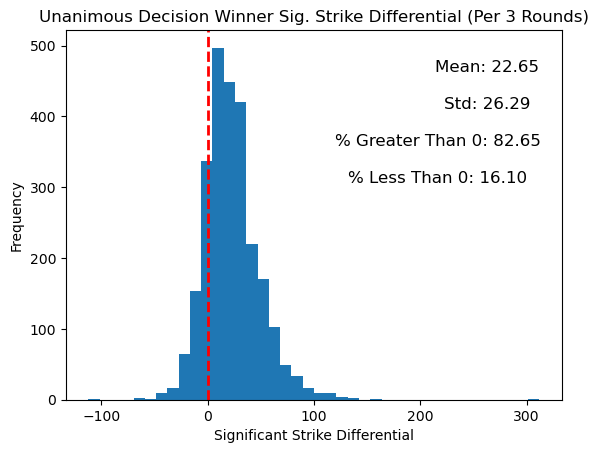

In [60]:
# Visualize Distribution of Winner Strike Differential in Unanimous Decision Fights

U_DEC = decision_data_1[decision_data_1["Method"] == "U-DEC"]
plt.hist(U_DEC["Diff_Str"], bins = 40)
mean_value = U_DEC["Diff_Str"].mean()
std_value = U_DEC["Diff_Str"].std()
greater_than_0 = (len(U_DEC[U_DEC["Diff_Str"] > 0])/len(U_DEC))*100
less_than_0 = (len(U_DEC[U_DEC["Diff_Str"] < 0])/len(U_DEC))*100
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.75, 0.7, f'% Greater Than 0: {greater_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.75, 0.6, f'% Less Than 0: {less_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel('Significant Strike Differential')
plt.ylabel('Frequency')
plt.title('Unanimous Decision Winner Sig. Strike Differential (Per 3 Rounds)')
plt.show()

The chart below shows the distribution of the winning fighter's takedown differential. The distribution is slightly right-skewed with a mean of 1.55 and standard deviation of 2.98. The chart suggests that winners of a unanimous decision are more likely to win the takedown battle, but, as with significant strikes, quite a few winning fighters lost the takedown battle.

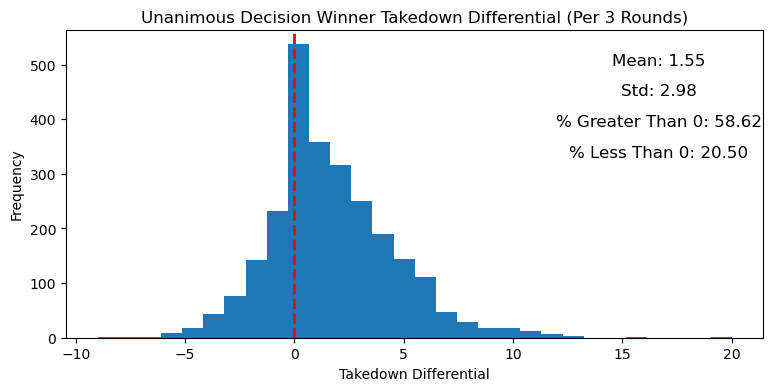

In [61]:
# Visualize Distribution of Winner Takedown Differential in Unanimous Decision Fights
plt.figure(figsize=(9,4))
plt.hist(U_DEC["Diff_Td"], bins = 30)
mean_value = U_DEC["Diff_Td"].mean()
std_value =  U_DEC["Diff_Td"].std()
greater_than_0 = (len(U_DEC[U_DEC["Diff_Td"] > 0])/len(U_DEC))*100
less_than_0 = (len(U_DEC[U_DEC["Diff_Td"] < 0])/len(U_DEC))*100
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.7, f'% Greater Than 0: {greater_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.6, f'% Less Than 0: {less_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel('Takedown Differential')
plt.ylabel('Frequency')
plt.title('Unanimous Decision Winner Takedown Differential (Per 3 Rounds)')
plt.show()

#### Split Decision Analysis

Split Decisions occur when one of the three judges scores the declared winner of the fight as the loser. As there is no consensus winner among the judges, these fights are inherently controversial. Thus, it is to be expected that the mean strike differential is to be smaller than those of a Unanimous Decision. The chart below bears this out. The distribution has little-to-no skew with a mean of 4.46 and 20.38 standard deviation. Additionally, many winners of split decisions actually lost the striking battle.

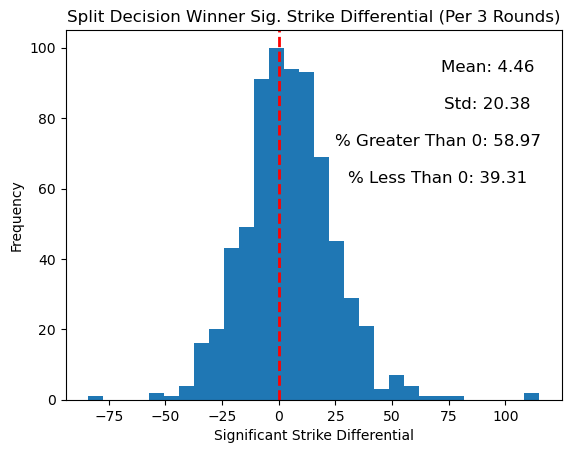

In [62]:
# Visualize Distribution of Winner Strike Differential in Split Decision Fights

S_DEC = decision_data_1[decision_data_1["Method"] == "S-DEC"]
plt.hist(S_DEC["Diff_Str"], bins = 30)
mean_value = S_DEC["Diff_Str"].mean()
std_value = S_DEC["Diff_Str"].std()
greater_than_0 = (len(S_DEC[S_DEC["Diff_Str"] > 0])/len(S_DEC))*100
less_than_0 = (len(S_DEC[S_DEC["Diff_Str"] < 0])/len(S_DEC))*100
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.75, 0.7, f'% Greater Than 0: {greater_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.75, 0.6, f'% Less Than 0: {less_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel("Significant Strike Differential")
plt.ylabel('Frequency')
plt.title('Split Decision Winner Sig. Strike Differential (Per 3 Rounds)')
plt.show()

In a similar fashion to the chart above, the distribution of the takedown differential has almost no skew. The mean is 0.23, and the standard deviation is 2.63. These two charts suggest that perhaps strike differential and takedown differential are not excellent predictors for the winner of a split decision. Perhaps more advanced striking and takedown data can assist in painting a higher-resolution picture of these fights.

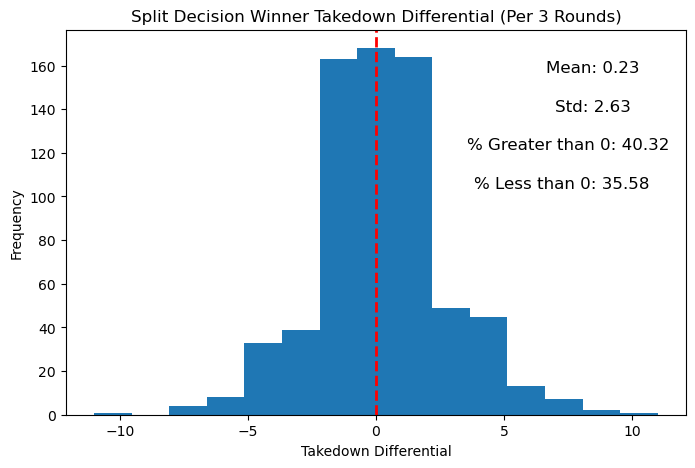

In [63]:
# Visualize Distribution of Winner Takedown Differential in Split Decision Fights
plt.figure(figsize=(8, 5))
plt.hist(S_DEC["Diff_Td"], bins = 15)
mean_value = S_DEC["Diff_Td"].mean()
std_value = S_DEC["Diff_Td"].std()
greater_than_0 = (len(S_DEC[S_DEC["Diff_Td"] > 0])/len(S_DEC))*100
less_than_0 = (len(S_DEC[S_DEC["Diff_Td"] < 0])/len(S_DEC))*100
plt.text(0.85, 0.9, f'Mean: {mean_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.85, 0.8, f'Std: {std_value:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.81, 0.7, f'% Greater than 0: {greater_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.text(0.8, 0.6, f'% Less than 0: {less_than_0:.2f}', fontsize=12, transform=plt.gca().transAxes, va='center', ha='center')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero')
plt.xlabel('Takedown Differential')
plt.ylabel('Frequency')
plt.title('Split Decision Winner Takedown Differential (Per 3 Rounds)')
plt.show()

What can be gleaned from this cursory analysis? In split decisions, it appears that Takedown Differential and Significant Strikes Differential will not be significant predictors in the model. It appears that some more "advanced" metrics will be necessary to include when building out the model.

# Model Selection

The goal of the model is to accurately predict fights and offer insight about the influence of features. As such, a logistic regression model has been chosen.

### Model for All Types of Fights

The goal of the first model is to predict the result of a fight without knowing anything about the type of decision. This model will provide a broad idea of what features are important when predicting any fight.

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from statsmodels.tools import add_constant

In [12]:
# Import the Data

data = pd.read_csv("model_data_1.csv")
data.head()

,Unnamed: 0,Method,Weight class,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
0,0,M-DEC,Middleweight,0,-2,-4,-1,0,3,-5,11,1,-14,-432,0
1,1,U-DEC,Lightweight,0,-18,-3,1,-4,-2,-12,-9,-4,-5,-286,0
2,2,U-DEC,Middleweight,0,7,1,0,10,8,-11,0,3,4,-218,0
3,3,U-DEC,Featherweight,0,2,-2,0,6,-4,0,12,-6,-4,-238,0
4,4,U-DEC,Women's Strawweight,-1,-27,1,0,16,18,-7,23,11,-7,-262,1


In [13]:
# Removing unnecessary columns

data = data.drop(data.columns[0], axis = 1)
data.head()

,Method,Weight class,Diff_Kd,Diff_Str,Diff_Td,Diff_Sub,Diff_Head,Diff_Body,Diff_Leg,Diff_Distance,Diff_Clinch,Diff_Ground,Diff_Ctrl,Fighter_1_W
0,M-DEC,Middleweight,0,-2,-4,-1,0,3,-5,11,1,-14,-432,0
1,U-DEC,Lightweight,0,-18,-3,1,-4,-2,-12,-9,-4,-5,-286,0
2,U-DEC,Middleweight,0,7,1,0,10,8,-11,0,3,4,-218,0
3,U-DEC,Featherweight,0,2,-2,0,6,-4,0,12,-6,-4,-238,0
4,U-DEC,Women's Strawweight,-1,-27,1,0,16,18,-7,23,11,-7,-262,1


### Checking for Multicollinearity

Before building the model, it is important to ensure that there is not multicollinearity within the data. First, a correlation matrix will be analyzed.

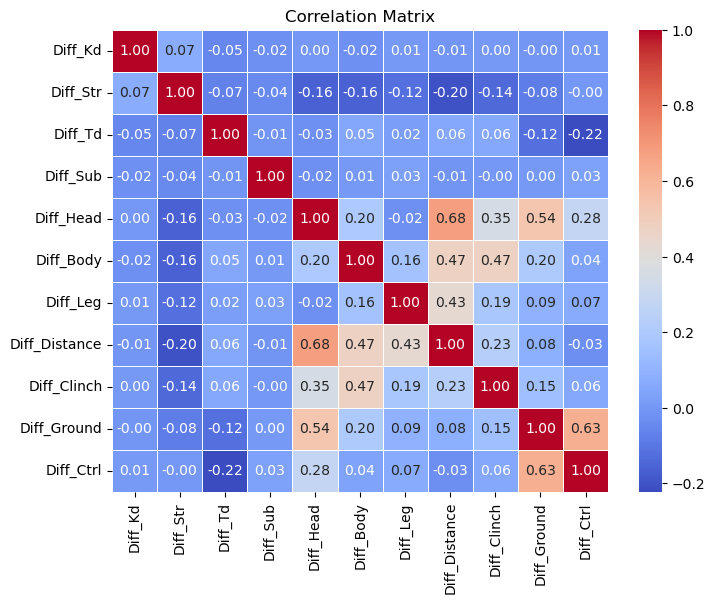

In [35]:
correlation_matrix = data[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head",
                          "Diff_Body", "Diff_Leg", "Diff_Distance", "Diff_Clinch",
                          "Diff_Ground", "Diff_Ctrl"]].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

Head Strikes Differential and Distance Strikes Differential are highly correlated, so Distance Strikes Differential is removed from the data used for modeling. Now, VIF scores are checked.

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
data_with_const = sm.add_constant(data[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head",
                          "Diff_Body", "Diff_Leg", "Diff_Clinch",
                          "Diff_Ground", "Diff_Ctrl"]])

# Calculate VIF for each variable
vif_data = pd.DataFrame()
vif_data["Variable"] = data_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(data_with_const.values, i) for i in range(data_with_const.shape[1])]

# Display the VIF values
print(vif_data)

       Variable       VIF
0         const  1.755790
1       Diff_Kd  1.008553
2      Diff_Str  1.070263
3       Diff_Td  1.064902
4      Diff_Sub  1.005223
5     Diff_Head  1.646237
6     Diff_Body  1.354418
7      Diff_Leg  1.084286
8   Diff_Clinch  1.476568
9   Diff_Ground  2.235665
10    Diff_Ctrl  1.737613


The VIF scores are all low, and so multicollinearity is not a concern. Now, the model can be built.

In [14]:
# Creating the training and testing set

import sklearn
from sklearn.model_selection import train_test_split

train, test = train_test_split(data,
                               test_size=0.3,
                               stratify=data['Method'],
                               random_state = 42)

In [15]:
# Adjusting the training and testing sets

X_train = train[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
y_train = train["Fighter_1_W"]
X_test = test[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
y_test = test["Fighter_1_W"]

In [16]:
# Creating the Model

features_1 = ["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_with_intercept = add_constant(X_train_scaled)

logit_model = sm.Logit(y_train,X_train_with_intercept)
result_1 = logit_model.fit()
print(result_1.summary(xname=["const"] + features_1))

Optimization terminated successfully.
         Current function value: 0.346389
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 2312
Model:                          Logit   Df Residuals:                     2301
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.4753
Time:                        01:28:47   Log-Likelihood:                -800.85
converged:                       True   LL-Null:                       -1526.4
Covariance Type:            nonrobust   LLR p-value:                8.855e-306
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8660      0.083     10.458      0.000       0.704       1.028
Diff_Kd         0.1662    

As seen in the table above, 8 of the 10 predictors used are significant in the model, with Submission Attempts Differential and Clinch Strikes Differential being insignificant. Head Strikes Differential and Control Time Differential are the predictors with the highest coefficients in the model. Now, let's see the accuracy score of the model.

In [17]:
X_test_scaled = scaler.transform(X_test)  # Use the same scaler as on the training set
X_test_with_intercept = add_constant(X_test_scaled)

# Predict on the test set
y_pred = result_1.predict(X_test_with_intercept)

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy_1 = (y_pred_binary == y_test).mean()
print(f"Accuracy: {accuracy_1:.2f}")

Accuracy: 0.86


Below, an amended model is made by making categorical variables from the insignificant predictors. If the fighter output in the insignificant features is greater than 95% (an arbitrarily chosen percentage) of the observations in that column, then that observation is changed to a 1. If the observation does not meet this criteria, it is changed to a 0.

In [18]:
X_train_adj = X_train.copy()

third_quartile_value = data["Diff_Clinch"].quantile(0.95)
X_train_adj.loc[:, "Diff_Clinch"] = X_train_adj["Diff_Clinch"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value_1 = data["Diff_Sub"].quantile(0.95)
X_train_adj.loc[:, "Diff_Sub"] = X_train_adj["Diff_Sub"].apply(lambda x: 1 if x > third_quartile_value_1 else 0)

In [19]:
X_test_adj = X_test.copy()

third_quartile_value = data["Diff_Clinch"].quantile(0.95)
X_test_adj.loc[:, "Diff_Clinch"] = X_test_adj["Diff_Clinch"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value_1 = data["Diff_Sub"].quantile(0.95)
X_test_adj.loc[:, "Diff_Sub"] = X_test_adj["Diff_Sub"].apply(lambda x: 1 if x > third_quartile_value_1 else 0)

In [20]:
# Creating the Model

features = ["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub_Cat", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Clinch_Cat", "Diff_Ground", "Diff_Ctrl"]
scaler = StandardScaler()
X_train_adj_scaled = scaler.fit_transform(X_train_adj)
X_train_adj_scaled_with_intercept = add_constant(X_train_adj_scaled)
X_train_adj_scaled_with_intercept

logit_model_adj = sm.Logit(y_train, X_train_adj_scaled_with_intercept)
result_adj = logit_model_adj.fit()
print(result_adj.summary(xname=["const"] + features))

Optimization terminated successfully.
         Current function value: 0.346313
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 2312
Model:                          Logit   Df Residuals:                     2301
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.4755
Time:                        01:28:55   Log-Likelihood:                -800.67
converged:                       True   LL-Null:                       -1526.4
Covariance Type:            nonrobust   LLR p-value:                7.435e-306
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.8726      0.083     10.460      0.000       0.709       1.036
Diff_Kd       

In [21]:
# Finding Accuracy

X_test_adj_scaled = scaler.transform(X_test_adj)  
X_test_adj_with_intercept = add_constant(X_test_adj_scaled)

y_pred = result_adj.predict(X_test_adj_with_intercept)

y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy_adj = (y_pred_binary == y_test).mean()
print(f"Accuracy: {accuracy_adj:.2f}")

Accuracy: 0.86


The same insignificatant predictors remain. The accuracy is still the same. I will now remove the remaining insignificant predictors.

In [22]:
features = ["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Ground", "Diff_Ctrl"]

X_train_adj.drop(["Diff_Sub", "Diff_Clinch"], axis=1, inplace=True)

scaler = StandardScaler()
X_train_adj_scaled = scaler.fit_transform(X_train_adj)
X_train_adj_scaled_with_intercept = add_constant(X_train_adj_scaled)
X_train_adj_scaled_with_intercept

logit_model_adj = sm.Logit(y_train, X_train_adj_scaled_with_intercept)
result_adj_1 = logit_model_adj.fit()
print(result_adj_1.summary(xname=["const"] + features))

Optimization terminated successfully.
         Current function value: 0.346617
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 2312
Model:                          Logit   Df Residuals:                     2303
Method:                           MLE   Df Model:                            8
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.4750
Time:                        01:29:21   Log-Likelihood:                -801.38
converged:                       True   LL-Null:                       -1526.4
Covariance Type:            nonrobust   LLR p-value:                8.244e-308
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8637      0.083     10.448      0.000       0.702       1.026
Diff_Kd         0.1662    

In [23]:
X_test_adj.drop(["Diff_Sub", "Diff_Clinch"], axis=1, inplace=True)

X_test_adj_scaled = scaler.transform(X_test_adj)  
X_test_adj_with_intercept = add_constant(X_test_adj_scaled)

y_pred = result_adj_1.predict(X_test_adj_with_intercept)

y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy_adj_1 = (y_pred_binary == y_test).mean()
print(f"Accuracy: {accuracy_adj_1:.2f}")

Accuracy: 0.86


This model has the same accuracy as all of the other models, but it only contains significant predictors. As such, this model would be chosen.

As said, the model above is useful when only the fighter output is known. However, it would be useful to build a model on a subset of the data used for the model above. The subset will be based on the type of decision. In creating this model, more insights can be gained about the impact of features once more is known about the interpretation of the competition.

### Unanimous Decision Model

First, a model will be created on fights that were scored a unanimous decision.

In [24]:
# Creating the training and testing sets

ud_train = train[train["Method"] == "U-DEC"]
ud_test = test[test["Method"] == "U-DEC"]

In [25]:
# Creating predictors and targets

ud_X_train = ud_train[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
ud_y_train =ud_train["Fighter_1_W"]
ud_X_test = ud_test[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
ud_y_test = ud_test["Fighter_1_W"]

In [26]:
# Building the model

features_2 = ["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]
scaler = StandardScaler()
ud_X_train_scaled = scaler.fit_transform(ud_X_train)
ud_X_train_with_intercept = add_constant(ud_X_train_scaled)

ud_logit_model = sm.Logit(ud_y_train, ud_X_train_with_intercept)
ud_result = ud_logit_model.fit()
print(ud_result.summary(xname=["const"] + features_2))

Optimization terminated successfully.
         Current function value: 0.233096
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 1778
Model:                          Logit   Df Residuals:                     1767
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.6433
Time:                        01:29:46   Log-Likelihood:                -414.44
converged:                       True   LL-Null:                       -1161.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2235      0.146      8.392      0.000       0.938       1.509
Diff_Kd         0.1968    

In the model above, Submission Attempts Differential and Clinch Strikes Differential are the only insignificant predictors. Head Strikes Differential and Control Time Differential are still the most impactful features by a considerable margin.

In [27]:
ud_X_test_scaled = scaler.transform(ud_X_test)  # Use the same scaler as on the training set
ud_X_test_with_intercept = add_constant(ud_X_test_scaled)

# Predict on the test set
ud_y_pred = ud_result.predict(ud_X_test_with_intercept)

# Convert predicted probabilities to binary predictions (0 or 1)
ud_y_pred_binary = (ud_y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy_2 = (ud_y_pred_binary == ud_y_test).mean()
print(f"Accuracy: {accuracy_2:.2f}")

Accuracy: 0.90


Below, an amended model is made by creating categorical variables in the same manner as the previos model.

In [28]:
ud_X_train_adj = ud_X_train.copy()

third_quartile_value = data["Diff_Clinch"].quantile(0.95)
ud_X_train_adj.loc[:, "Diff_Clinch"] = ud_X_train_adj["Diff_Clinch"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Sub"].quantile(0.95)
ud_X_train_adj.loc[:, "Diff_Sub"] = ud_X_train_adj["Diff_Sub"].apply(lambda x: 1 if x > third_quartile_value else 0)

In [29]:
ud_X_test_adj = ud_X_test.copy()

third_quartile_value = data["Diff_Clinch"].quantile(0.95)
ud_X_test_adj.loc[:, "Diff_Clinch"] = ud_X_test_adj["Diff_Clinch"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Sub"].quantile(0.95)
ud_X_test_adj.loc[:, "Diff_Sub"] = ud_X_test_adj["Diff_Sub"].apply(lambda x: 1 if x > third_quartile_value else 0)

In [30]:
features_3 = ["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub_Cat", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Clinch_Cat", "Diff_Ground", "Diff_Ctrl"]
scaler = StandardScaler()
ud_X_train_adj_scaled = scaler.fit_transform(ud_X_train_adj)
ud_X_train_adj_with_intercept = add_constant(ud_X_train_adj_scaled)

ud_logit_model_adj = sm.Logit(ud_y_train, ud_X_train_adj_with_intercept)
ud_result_adj = ud_logit_model_adj.fit()
print(ud_result_adj.summary(xname=["const"] + features_3))

Optimization terminated successfully.
         Current function value: 0.233651
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 1778
Model:                          Logit   Df Residuals:                     1767
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.6424
Time:                        01:30:20   Log-Likelihood:                -415.43
converged:                       True   LL-Null:                       -1161.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.2198      0.146      8.341      0.000       0.933       1.506
Diff_Kd       

None of the insignificant predictors become significant.

In [243]:
ud_X_test_scaled_adj = scaler.transform(ud_X_test_adj)  
ud_X_test_with_intercept_adj = add_constant(ud_X_test_scaled_adj)

ud_y_pred = ud_result_adj.predict(ud_X_test_with_intercept_adj)

ud_y_pred_binary = (ud_y_pred > 0.5).astype(int)

accuracy_3 = (ud_y_pred_binary == ud_y_test).mean()
print(f"Accuracy: {accuracy_3:.2f}")

Accuracy: 0.91


The accuracy score in the new model actually improves using the new model. Now, I will try a new model that does not have any insignificant predictors.

In [31]:
features = ["Diff_Str", "Diff_Td", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Ground", "Diff_Ctrl"]

ud_X_train_adj.drop(["Diff_Sub", "Diff_Clinch", "Diff_Kd"], axis = 1, inplace = True)

scaler = StandardScaler()
ud_X_train_adj_scaled = scaler.fit_transform(ud_X_train_adj)
ud_X_train_adj_with_intercept = add_constant(ud_X_train_adj_scaled)

ud_logit_model_adj = sm.Logit(ud_y_train, ud_X_train_adj_with_intercept)
ud_result_adj_1 = ud_logit_model_adj.fit()
print(ud_result_adj_1.summary(xname=["const"] + features))

Optimization terminated successfully.
         Current function value: 0.234980
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 1778
Model:                          Logit   Df Residuals:                     1770
Method:                           MLE   Df Model:                            7
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.6404
Time:                        01:31:22   Log-Likelihood:                -417.79
converged:                       True   LL-Null:                       -1161.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2145      0.145      8.390      0.000       0.931       1.498
Diff_Str        0.5227    

In [32]:
ud_X_test_adj.drop(["Diff_Sub", "Diff_Clinch", "Diff_Kd"], axis = 1, inplace = True)

ud_X_test_scaled_adj = scaler.transform(ud_X_test_adj)  
ud_X_test_with_intercept_adj = add_constant(ud_X_test_scaled_adj)

ud_y_pred = ud_result_adj_1.predict(ud_X_test_with_intercept_adj)

ud_y_pred_binary = (ud_y_pred > 0.5).astype(int)

accuracy = (ud_y_pred_binary == ud_y_test).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


The accuracy remains the same, but the model only contains significant

### Split Decision Model

In [213]:
sd_train = train[train["Method"] == "S-DEC"]
sd_test = test[test["Method"] == "S-DEC"]

In [214]:
sd_X_train = sd_train[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Body", "Diff_Leg", 
               "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
sd_y_train = sd_train["Fighter_1_W"]
sd_X_test = sd_test[["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Body", "Diff_Leg", 
               "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]]
sd_y_test = sd_test["Fighter_1_W"]

In [215]:
features = ["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Head", "Diff_Body", "Diff_Leg", 
            "Diff_Clinch", "Diff_Ground", "Diff_Ctrl"]
scaler = StandardScaler()
sd_X_train_scaled = scaler.fit_transform(sd_X_train)
sd_X_train_with_intercept = add_constant(sd_X_train_scaled)

sd_logit_model = sm.Logit(sd_y_train, sd_X_train_with_intercept)
sd_result = sd_logit_model.fit()
print(sd_result.summary(xname=["const"] + features))

Optimization terminated successfully.
         Current function value: 0.615246
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                  477
Model:                          Logit   Df Residuals:                      466
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                 0.09707
Time:                        01:08:01   Log-Likelihood:                -293.47
converged:                       True   LL-Null:                       -325.02
Covariance Type:            nonrobust   LLR p-value:                 9.337e-10
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3484      0.100      3.489      0.000       0.153       0.544
Diff_Kd         0.1818    

The table indicates that the Pseud0 R-Squared Value is much lower than the above models. Only 3 predictors are significant in the model above: Head Strikes Differential, Clinch Strikes Differential, and Control Time Differential.

In [216]:
sd_X_test_scaled = scaler.transform(sd_X_test)  # Use the same scaler as on the training set
sd_X_test_with_intercept = add_constant(sd_X_test_scaled)

# Predict on the test set
sd_y_pred = sd_result.predict(sd_X_test_with_intercept)

# Convert predicted probabilities to binary predictions (0 or 1)
sd_y_pred_binary = (sd_y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = (sd_y_pred_binary == sd_y_test).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.61


An accuracy score of 0.61 is lower than desired, as the goal score was 0.67 or higher (as 2 of the 3 judges agree on the winner). To address this, the insignificant predictors are adjusted as they were in the other models.

In [217]:
sd_X_train_adj = sd_X_train.copy()

third_quartile_value = data["Diff_Str"].quantile(0.90)
sd_X_train_adj.loc[:, "Diff_Str"] = sd_X_train_adj["Diff_Str"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Td"].quantile(0.90)
sd_X_train_adj.loc[:, "Diff_Td"] = sd_X_train_adj["Diff_Td"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Sub"].quantile(0.90)
sd_X_train_adj.loc[:, "Diff_Sub"] = sd_X_train_adj["Diff_Sub"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Body"].quantile(0.90)
sd_X_train_adj.loc[:, "Diff_Body"] = sd_X_train_adj["Diff_Body"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Leg"].quantile(0.90)
sd_X_train_adj.loc[:, "Diff_Leg"] = sd_X_train_adj["Diff_Leg"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Ground"].quantile(0.90)
sd_X_train_adj.loc[:, "Diff_Ground"] = sd_X_train_adj["Diff_Ground"].apply(lambda x: 1 if x > third_quartile_value else 0)

In [218]:
sd_X_test_adj = sd_X_test.copy()

third_quartile_value = data["Diff_Str"].quantile(0.90)
sd_X_test_adj.loc[:, "Diff_Str"] = sd_X_test_adj["Diff_Str"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Td"].quantile(0.90)
sd_X_test_adj.loc[:, "Diff_Td"] = sd_X_test_adj["Diff_Td"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Sub"].quantile(0.90)
sd_X_test_adj.loc[:, "Diff_Sub"] = sd_X_test_adj["Diff_Sub"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Body"].quantile(0.90)
sd_X_test_adj.loc[:, "Diff_Body"] = sd_X_test_adj["Diff_Body"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Leg"].quantile(0.90)
sd_X_test_adj.loc[:, "Diff_Leg"] = sd_X_test_adj["Diff_Leg"].apply(lambda x: 1 if x > third_quartile_value else 0)

third_quartile_value = data["Diff_Ground"].quantile(0.90)
sd_X_test_adj.loc[:, "Diff_Ground"] = sd_X_test_adj["Diff_Ground"].apply(lambda x: 1 if x > third_quartile_value else 0)

In [219]:
features = ["Diff_Kd_Cat", "Diff_Str_Cat", "Diff_Td_Cat", "Diff_Sub_Cat", "Diff_Head", "Diff_Body_Cat", "Diff_Leg_Cat", 
            "Diff_Clinch", "Diff_Ground_Cat", "Diff_Ctrl"]
scaler = StandardScaler()
sd_X_train_adj_scaled = scaler.fit_transform(sd_X_train_adj)
sd_X_train_adj_with_intercept = add_constant(sd_X_train_adj_scaled)

sd_adj_logit_model = sm.Logit(sd_y_train, sd_X_train_adj_with_intercept)
sd_result_adj = sd_adj_logit_model.fit()
print(sd_result_adj.summary(xname=["const"] + features))

Optimization terminated successfully.
         Current function value: 0.619419
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                  477
Model:                          Logit   Df Residuals:                      466
Method:                           MLE   Df Model:                           10
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                 0.09095
Time:                        01:08:11   Log-Likelihood:                -295.46
converged:                       True   LL-Null:                       -325.02
Covariance Type:            nonrobust   LLR p-value:                 5.313e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3509      0.099      3.533      0.000       0.156       0.546
Diff_Kd         0.1576    

In [220]:
sd_X_test_scaled_adj = scaler.transform(sd_X_test_adj)  # Use the same scaler as on the training set
sd_X_test_with_intercept_adj = add_constant(sd_X_test_scaled_adj)

# Predict on the test set
sd_y_pred = sd_result_adj.predict(sd_X_test_with_intercept_adj)

# Convert predicted probabilities to binary predictions (0 or 1)
sd_y_pred_binary = (sd_y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = (sd_y_pred_binary == sd_y_test).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.63


The accuracy score increases when the model is adjusted. What if all insignificant predictors are simply dropped?

In [221]:
features = ["Diff_Head", "Diff_Clinch", "Diff_Ctrl"]

sd_X_train_adj.drop(["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Body", "Diff_Leg", "Diff_Ground"], axis = 1, inplace = True)
scaler = StandardScaler()
sd_X_train_adj_scaled = scaler.fit_transform(sd_X_train_adj)
sd_X_train_adj_with_intercept = add_constant(sd_X_train_adj_scaled)

sd_adj_logit_model = sm.Logit(sd_y_train, sd_X_train_adj_with_intercept)
sd_result_adj = sd_adj_logit_model.fit()
print(sd_result_adj.summary(xname=["const"] + features))

Optimization terminated successfully.
         Current function value: 0.627974
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                  477
Model:                          Logit   Df Residuals:                      473
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                 0.07839
Time:                        01:08:20   Log-Likelihood:                -299.54
converged:                       True   LL-Null:                       -325.02
Covariance Type:            nonrobust   LLR p-value:                 4.991e-11
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3420      0.098      3.483      0.000       0.150       0.534
Diff_Head       0.4052    

In [222]:
sd_X_test_adj.drop(["Diff_Kd", "Diff_Str", "Diff_Td", "Diff_Sub", "Diff_Body", "Diff_Leg", "Diff_Ground"], axis = 1, inplace = True)

sd_X_test_scaled_adj = scaler.transform(sd_X_test_adj)  # Use the same scaler as on the training set
sd_X_test_with_intercept_adj = add_constant(sd_X_test_scaled_adj)

# Predict on the test set
sd_y_pred = sd_result_adj.predict(sd_X_test_with_intercept_adj)

# Convert predicted probabilities to binary predictions (0 or 1)
sd_y_pred_binary = (sd_y_pred > 0.5).astype(int)

# Calculate accuracy
accuracy = (sd_y_pred_binary == sd_y_test).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.62


Although the accuracy in the model is slightly lower than the model before, it only contains significant predictors, and so this is the model that would be selected.

### Final Models

Below are the best models as associated accuracy scores.

#### Model for All Fights

In [210]:
# Model
print(result_adj_1.summary(xname=["const"] + features))

                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 2312
Model:                          Logit   Df Residuals:                     2303
Method:                           MLE   Df Model:                            8
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.4750
Time:                        01:07:37   Log-Likelihood:                -801.38
converged:                       True   LL-Null:                       -1526.4
Covariance Type:            nonrobust   LLR p-value:                8.244e-308
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.8637      0.083     10.448      0.000       0.702       1.026
Diff_Kd         0.1662      0.066      2.516      0.012       0.037       0.296
Diff_Str        0.3665      0.103      3.552    

In [212]:
# Accuracy for Model
print(f"Accuracy: {accuracy_adj_1:.2f}")

Accuracy: 0.86


#### Model for Unanimous Decisions

In [248]:
# Model
print(ud_result_adj_1.summary(xname=["const"] + features))

                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                 1778
Model:                          Logit   Df Residuals:                     1770
Method:                           MLE   Df Model:                            7
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                  0.6404
Time:                        01:12:06   Log-Likelihood:                -417.79
converged:                       True   LL-Null:                       -1161.7
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2145      0.145      8.390      0.000       0.931       1.498
Diff_Str        0.5227      0.160      3.277      0.001       0.210       0.835
Diff_Td         0.2160      0.104      2.083    

In [249]:
# Accuracy for Model
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.91


#### Model for Split Decisions

In [223]:
# Model
print(sd_result_adj.summary(xname=["const"] + features))

                           Logit Regression Results                           
Dep. Variable:            Fighter_1_W   No. Observations:                  477
Model:                          Logit   Df Residuals:                      473
Method:                           MLE   Df Model:                            3
Date:                Tue, 12 Dec 2023   Pseudo R-squ.:                 0.07839
Time:                        01:09:21   Log-Likelihood:                -299.54
converged:                       True   LL-Null:                       -325.02
Covariance Type:            nonrobust   LLR p-value:                 4.991e-11
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3420      0.098      3.483      0.000       0.150       0.534
Diff_Head       0.4052      0.107      3.774      0.000       0.195       0.616
Diff_Clinch     0.3990      0.111      3.602    

In [224]:
# Accuracy for Model
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.62


## Conclusions

### Takeaways from the Logistic Regression Models

Based on the first model, which does not take into account the type of outcome, one can determine that Significant Strike Differential, Takedown Differential, Strikes to the Head Differential, Strikes to the Body Differential, Leg Kicks Differential, Control Time Differential, Ground Strikes Differential, and Knockdown Differential are the most important features when predicting the winner of a fight, with Strikes to the Head Differential and Control Time Differential having the largest impact on the judges' scorecards. This is not terribly surprising, as these two features are perhaps the best indicators of effective striking and effective grappling, which are the two most important standards by which judges are supposed to score fights. The next two important features are Body Strike Differential and Leg Kicks Differential, respectively, which are also indicators of effective striking. However, the main idea is that, since there are multiple significant predictors, a fighter can find success in a fight by gaining advantages in a variety of areas. That being said, certain parts of their output, namely Strikes to the Head Differential and Control Time Differential, should be prioritized.

The Unanimous Decision Model offers similar insights. When all judges agree on a winner, the model suggests that there are multiple different areas in the fight that offer significant insight on who won. Interestingly, Knockdown Differential is not a significant predictor when modeling on this subset of the data. All this being said, Strikes to the Head Differential and Control Time Differential are still the most impactful predictors.

What is perhaps most surprising are the takeaways from the Split Decision Model. Based on the EDA, there were doubts as to whether there would be any significant predictors from the features in the data. While the number of significant predictors in the model are lower than the other two models, Strikes to the Head Differential and Control Time Differential were significant and still have the largest coefficients. This would indicate that in a close fight, the features most strongly related to the most important judging criterion play the most significant role in a judge's mind when discerning the winner in a close fight. This sort of information would be particularly useful to fighters and coaches, as if the fight is close and the fight is coming to an end, a strategy could be formed so as to gain advantages in the competition.